# ***Improving retention with long short-term memory networks***

**Author**: Shubham Sharma
  
**Assertion Statement**: I wrote all of the explanatory text and comments in this notebook. The was adapted from [Natural Language Processing in Action - Chapter 9](https://livebook.manning.com/book/natural-language-processing-in-action/chapter-9/1)

## **Introduction**

In any language, tokens may be deeply interrelated even when they are far apart in a sentence. For example, in a sentence like **"The young woman went to the movies with her friends"**, the subject “woman” immediately precedes its main verb “went.” For sentence like these, traditional RNNs and CNNs will have no problem in learning the relationship.

But for a sentence like "**The young woman, having found a free ticket on the ground, went to the movies**", the noun and verb are no longer one time step apart in the sequence. Traditional RNNs have one major drawback: a token’s effect is almost completely lost by the time two tokens have
passed. So, it will have difficulty picking up the relationship between "woman" and "went" and it will overemphasize on the relationship between the words "woman" and "having" which are one time step apart. 

Traditional RNNs suffer from 2 problems:
- Vanishing Gradients
- Exploding Gradients

The weights in a recurrent network decay too quickly in time as you roll through each sentence. 

An LSTM (Long short-term memory) can overcome this drawback as it can remember important time events in the past across the entire input sequence. LSTMs work so well they have replaced recurrent neural networks in almost all applications involving time series, discrete sequences, and NLP.

## **LSTM**

LSTMs introduce the concept of a state for each layer in the recurrent network. The state acts as its memory.

Below is an LSTM network and its memory. 

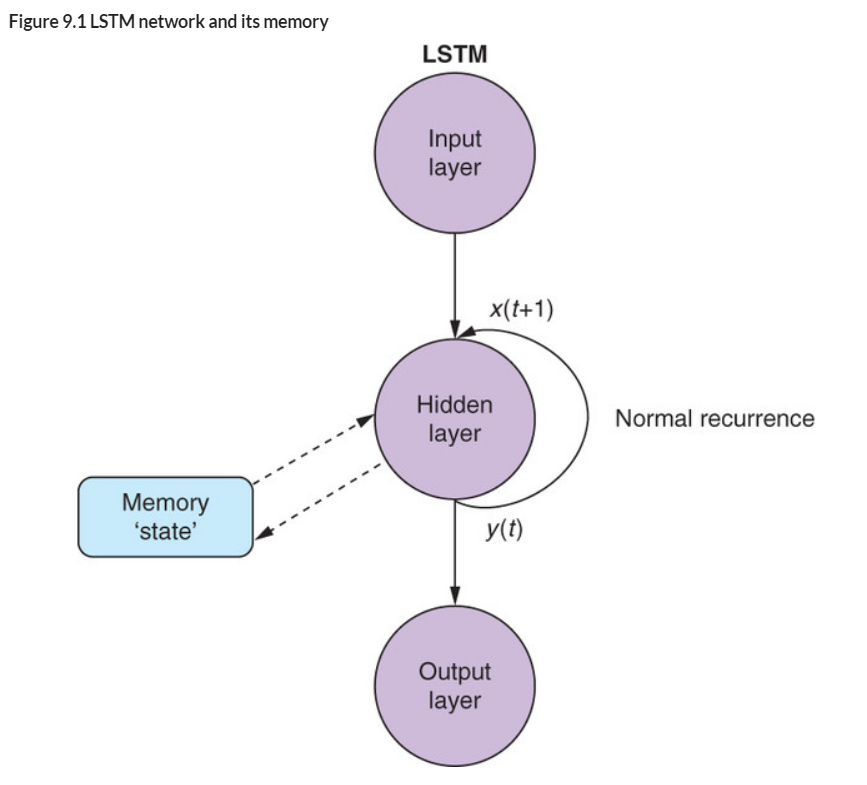

One difference that we can observe is a "memory state". It learns what to remember and at the same time it also learns to reproduce the output, using standard backpropagation. The memory state is affected by the input and also affects the layer output just as in a normal recurrent net.

Let us unroll the network in time. We can see the memory state passes through the time steps of the network. At each time-step iteration, the hidden recurrent unit has access to the memory unit. So, at each time step, we are passing the previous hidden layer activation output and the current input along with an access to the memory state. 


### **LSTM layer at time step t**

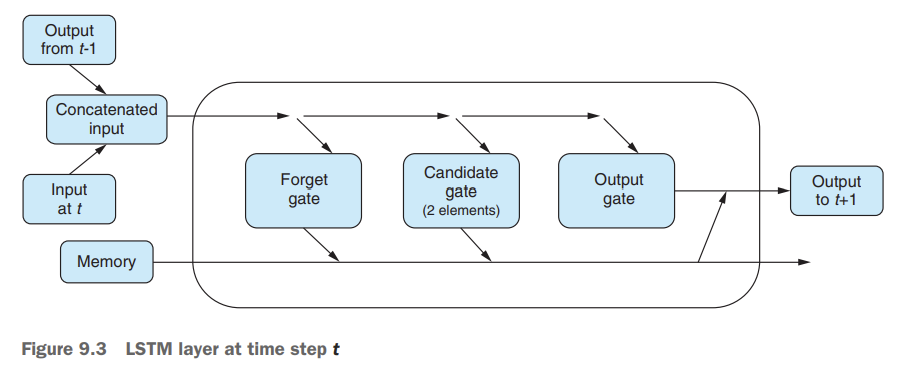

As before, the input to the layer (or cell) is a combination of the input sample and output from the previous time step. As information flows into the
cell instead of a vector of weights, it’s now greeted by three gates: 
- forget gate 
- input/candidate gate
- output gate

Each of these gates is a feed-forward neural network compose of a series of weights that the network will learn, plus an activation function. 

In [1]:
# 9.1 LSTM Layer in Keras

# We are defining a sequential model that consists of one LSTM layer. 
# We have used Dropout Regularization to prevent overfitting.

maxlen = 400
batch_size = 32
embedding_dims = 300
epochs = 2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
num_neurons = 50
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 50)           70200     
                                                                 
 dropout (Dropout)           (None, 400, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________
None


In the above code, we see, when we replace "SimpleRNN" with "LSTM", we have lot more parameters to train for the same number of neurons. Since, each cell has 3 gates which themselves are feed-forward neural networks, we need to learn those parameters as well. 

**The memory is going to be represented by a vector that is the
same number of elements as neurons in the cell. Since we have 50 neurons, the memory unit will be a vector of floats that is 50 elements long.**

Each word is represented by a 300-dimension vector. The first step is to concatenate the output of the previous time step (which is a 0 vector in the first time step) and the current input (300-element vector of the first word in the first sample) and pass into the first LSTM cell. We also add a bias term of 1. In the above case, since we have 50 neurons and each word is represented by 300 dimensional vector, we will have a vector that is 351 elements long. 

This combined input vector is passed to the forget gate. The forget gate’s goal is to learn, based on a given input, how much of the cell’s memory we want to erase.

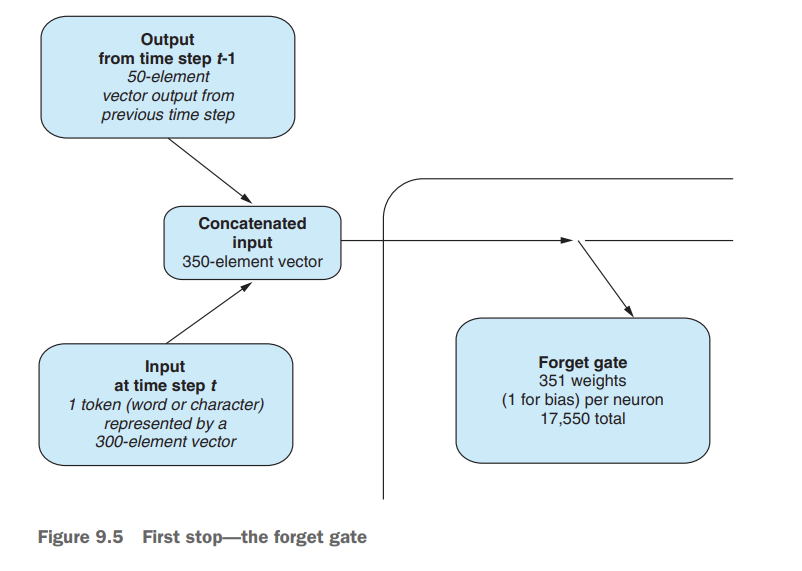

An LSTM must model not only long-term dependencies within a
sequence, but just as crucially, also forget long-term dependencies as new ones arise. This is what forgetting gates are for, making room for the relevant memories in your memory cells.

As an example, consider the following sentence - "**A thinker sees his own actions as experiments and questions—as attempts to find out something. Success and failure are for him answers above all.**" "Success" and "Failure" nouns are related to thinker but we can not use "is". We have to use "are" and that is due to new dependency risen from the words success and failure. 

***The forget gate itself is just a feed forward network***. It consists of n neurons each with m + n + 1 weights. So in our example forget gate has 50 neurons each with 351 (300 + 50 + 1) weights. The activation function for a forget gate is the sigmoid function, because we want the output for each neuron in the gate to be between 0 and 1. Forget gate decides how much of the previous data will be forgotten and how much of the previous data will be used in next steps. The result of this gate is in the range of 0-1 while "0" forgets the previous data, "1" uses the previous data.

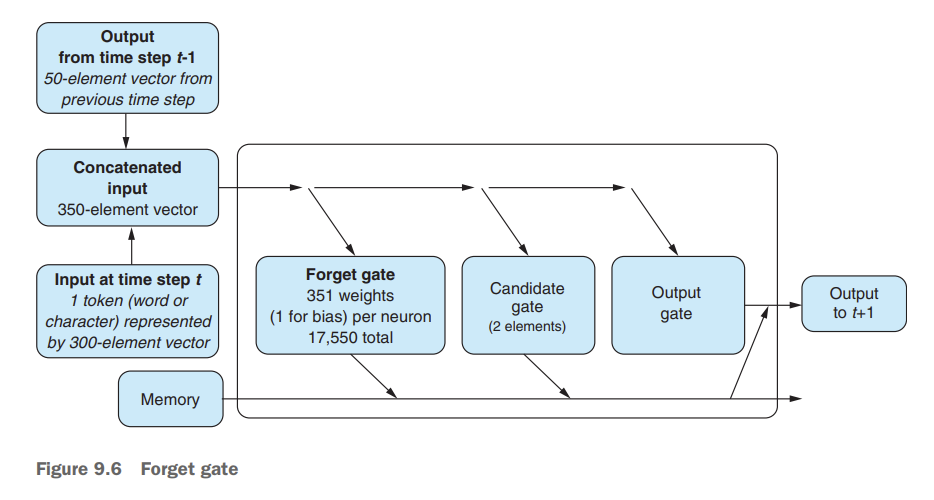

In [2]:
!pip install -q nlpia

In [3]:
# Import all the things
import glob
import os
from random import shuffle
from nltk.tokenize import TreebankWordTokenizer

In [4]:
# In the book below code is mentioned - 

# from nlpia.loaders import get_data
# word_vectors = get_data('wv')

# Above code was not working for me in Colab, But, it was working on my local in Jupyter Notebook.

# So, I used the code below to load the word vectors.
# First, I uploaded "GoogleNews-vectors-negative300.bin" from https://github.com/mmihaltz/word2vec-GoogleNews-vectors to my Google Drive.
# It is pre-trained model trained on Google news data.
# Then, using gensim, load the word embeddings. 

# Load a pretrained Word2vec model using gensim.

# Mount Google drive (allow access when asked)
from google.colab import drive
drive.mount('drive')

# Load vectors directly from the file (Takes around 1.5 minutes to run)
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin', binary=True)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [5]:
# There are Word2Vec embeddings for 3 million words. 
len(word_vectors.index2word)

3000000

### **Defining functions to preprocess the data**

In [6]:
# DATA PREPROCESSOR

# Dataset folder "train" consists of two folders, train and test. 
# In each folder, there are 2 sub-folders, pos and neg which consists of text files.
# For files in "pos" folder, we read them one by one and append 1 before text because of the positive sentiment.
# Similarly for negative files, we append 0 before text.

def pre_process_data(filepath):
    """
    Load pos and neg examples from separate dirs then shuffle them
    together.
    """
    positive_path = os.path.join(filepath, 'pos')    # 
    negative_path = os.path.join(filepath, 'neg')
    pos_label = 1
    neg_label = 0
    dataset = []
    for filename in glob.glob(os.path.join(positive_path, '*.txt')):
      with open(filename, 'r') as f:
        dataset.append((pos_label, f.read()))
    for filename in glob.glob(os.path.join(negative_path, '*.txt')):
      with open(filename, 'r') as f:
        dataset.append((neg_label, f.read()))

    return dataset

###########################-------------------------------####################################
# DATA TOKENIZER AND VECTORIZER

# We tokenize the data according to NLTK's TreebankWordTokenizer and vectorize the words
# using our pre-trained word embeddings.

def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    for sample in dataset:
      tokens = tokenizer.tokenize(sample[1]) # sample[0] is the label, sample[1] is the text.
      sample_vecs = []
      for token in tokens:
        try:
          sample_vecs.append(word_vectors[token])
        except KeyError:
          # No matching token in the Google w2v vocab
          pass 
      vectorized_data.append(sample_vecs)
    return vectorized_data


###########################-------------------------------####################################
#  TARGET UNZIPPER

# sample[0] is the sentiment label (1 - positive, 0 - negative)
# We are storing all the target labels in a list called expected.
# This will be later used to create the test data.

def collect_expected(dataset):
    """ Peel off the target values from the dataset """
    expected = []
    for sample in dataset:
      expected.append(sample[0])
    return expected


###########################-------------------------------####################################
# PADDING AND TRUNCATING THE TOKEN SEQUENCE

# Keras has a preprocessing helper method, pad_sequences, that in theory could be
# used to pad the input data, but unfortunately it works only with sequences of scalars,
# and we have sequences of vectors. 
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

def pad_trunc(data, maxlen):
    """
    For a given dataset pad with zero vectors or truncate to maxlen
    """
    new_data = []
    # Create a vector of 0s the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
      zero_vector.append(0.0)
    for sample in data:
      if len(sample) > maxlen:
        temp = sample[:maxlen]
      elif len(sample) < maxlen:
        temp = sample
        # Append the appropriate number 0 vectors to the list
        additional_elems = maxlen - len(sample)
        for _ in range(additional_elems):
          temp.append(zero_vector)
      else:
        temp = sample
      new_data.append(temp)
    return new_data

### **Training and Saving the model**


In [7]:
# 9.2 Load and Prepare the IMDB data

filepath = '/content/drive/My Drive/imdb/train'

from random import sample, seed
seed(42)

import numpy as np
dataset = pre_process_data(filepath)               

# When we try to reshape x_train (to convert padded data to numpy array) 
# including the whole dataset, it requires a lot of RAM and Kernel is crashing.
# I have countered that problem by sampling the data and not using the entire train data.

# We need to sample the dataset to get equal distribution 
# of positive and negative samples in train and test data.
# For this, I am using the random.sample() method. 

dataset = sample(dataset, 5000)   # This will randomly shuffle the data
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)               # Getting the target labels

In [8]:
min([len(vectorized_data[i]) for i in range(len(vectorized_data))]), max([len(vectorized_data[i]) for i in range(len(vectorized_data))])
# Minimum tokens in a sentence are 8, Maximum tokens are 1557.

(8, 1557)

In [9]:
# Sentence with minimum tokens
dataset[np.argmin([len(vectorized_data[i]) for i in range(len(vectorized_data))])]

(0, 'Ming The Merciless does a little Bardwork and a movie most foul!')

In [10]:
# Split the data into training and testing sets

split_point = int(len(vectorized_data) * .8)
x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

In [11]:
# We can see training and test set have almost equal distribution of positive and negative samples. 
y_train.count(1), y_train.count(0), y_test.count(1), y_test.count(0)

(1972, 2028, 494, 506)

In [12]:
# Declare the hyperparameters.
maxlen = 400                             # Arbitrary sequence length based on perusing the data
batch_size = 32                          # Number of sample sequences to pass through (and aggregate the error) before backpropagating                
embedding_dims = 300                     # From the pretrained Word2vec model
epochs = 2

# Pass the train and test data into the padder/truncator.
# We don’t usually need to pad or truncate with recurrent neural nets, because 
# they can handle input sequences of variable length. But this particular model 
# requires sequences to be of matching length.

# Pad/Truncate the sequences to 400 tokens
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

# Convert the padded data to numpy arrays. LSTM expects input data to be a 3D tensor.
# This is a tensor with the shape (number of samples, sequence length, word vector length).
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

In [13]:
#9.3 Build a Keras LSTM network

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
num_neurons = 50

model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

# Flatten the output of LSTM
model.add(Flatten())

# A one neuron layer that will output a float between 0 and 1.
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 400, 50)           70200     
                                                                 
 dropout_1 (Dropout)         (None, 400, 50)           0         
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________


After the Flatten() layer, the input is a 20,000-dimensional
vector plus the one bias input. The total number of parameters for the Dense layer is (20,000 input elements + 1 bias unit) * 1 neuron = 20,001 parameters

In [14]:
#9.4 Fit your LSTM model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
125/125 [==============================] - 7s 33ms/step - loss: 0.5830 - accuracy: 0.6745 - val_loss: 0.5032 - val_accuracy: 0.7650
Epoch 2/10
125/125 [==============================] - 3s 24ms/step - loss: 0.4451 - accuracy: 0.7968 - val_loss: 0.4550 - val_accuracy: 0.7960
Epoch 3/10
125/125 [==============================] - 3s 24ms/step - loss: 0.3731 - accuracy: 0.8263 - val_loss: 0.4498 - val_accuracy: 0.7820
Epoch 4/10
125/125 [==============================] - 3s 24ms/step - loss: 0.2971 - accuracy: 0.8770 - val_loss: 0.4102 - val_accuracy: 0.8080
Epoch 5/10
125/125 [==============================] - 3s 24ms/step - loss: 0.2412 - accuracy: 0.9120 - val_loss: 0.4187 - val_accuracy: 0.8180
Epoch 6/10
125/125 [==============================] - 3s 24ms/step - loss: 0.1991 - accuracy: 0.9250 - val_loss: 0.4231 - val_accuracy: 0.8240
Epoch 7/10
125/125 [==============================] - 3s 24ms/step - loss: 0.1528 - accuracy: 0.9473 - val_loss: 0.5169 - val_accuracy: 0.8100

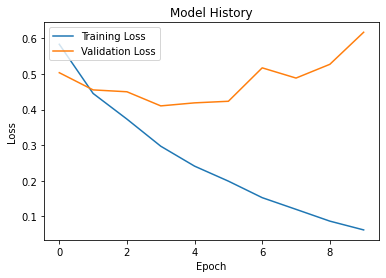

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In the above plot, we expect training loss to decrease for however number of epochs but we see validation loss starts increasing after 3 epochs. This is a sign of overfitting. In this way, LSTM will learn to model words present in training data and will not generalize well. 

We will choose number of epochs as 3 keeping every other hyperparameter same. 

In [16]:
# Reducing epochs to 3 to avoid overfitting.
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
125/125 [==============================] - 4s 29ms/step - loss: 0.0499 - accuracy: 0.9855 - val_loss: 0.6438 - val_accuracy: 0.8190
Epoch 2/3
125/125 [==============================] - 3s 24ms/step - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.6916 - val_accuracy: 0.8170
Epoch 3/3
125/125 [==============================] - 3s 24ms/step - loss: 0.0279 - accuracy: 0.9930 - val_loss: 1.0311 - val_accuracy: 0.7730


We get an accuracy of ~80% which is not bad for a small dataset with 5000 sentences. If RAM was not an issue, we could have tried two things to increase our accuracy.

- Use all the sentences present in the "train" folder (25000).

- There is a folder "test" in our IMDB dataset. We could use both folders to increase the size of data.

I also tried to increase the number of neurons and played around with batch size (32, 64, 128) but the accuracy was around ~80% in all cases.

In [17]:
#9.5 Saving the model as a JSON so we don't have to train again

model_structure = model.to_json()
with open("/content/drive/My Drive/imdb/lstm_model1.json", "w") as json_file:
  json_file.write(model_structure)
model.save_weights("lstm_weights1.h5")

### **With a trained model, we can begin trying out various sample phrases and seeing how well the model performs.**

In [18]:
# 9.6 Reload LSTM model
from keras.models import model_from_json
with open("/content/drive/My Drive/imdb/lstm_model1.json", "r") as json_file:
  json_string = json_file.read()
model = model_from_json(json_string)
model.load_weights('lstm_weights1.h5')

In [19]:
# 9.7 Use the model to predict on a sample

sample_1 = """I hate that the dismal weather had me down for so long,
    when will it break! Ugh, when does happiness return? The sun is
    blinding and the puffy clouds are too thin. I can't wait for the
    weekend."""

# We pass a dummy value in the first element of the tuple because of the way we created the function. 
# That value can be anything as the network won't see it.
vec_list = tokenize_and_vectorize([(1, sample_1)])
test_vec_list = pad_trunc(vec_list, maxlen)
test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

# ORIGINAL CODE FROM BOOK
# print("Sample's sentiment, 1 - pos, 2 - neg : {}".format(model.predict_classes(test_vec)))

# model.predict_classes(test_vec) was giving error 
# "AttributeError: 'Sequential' object has no attribute 'predict_classes'"
# Instead of using predict_classes, I have used predict

# https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes
print("Sample's sentiment, 1 - pos, 2 - neg : {}".format((model.predict(test_vec) > 0.5).astype("int32")))
print("-----------------------------------------------------")
print("Raw output of sigmoid function: {}".format(model.predict(test_vec)))

Sample's sentiment, 1 - pos, 2 - neg : [[0]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.07713173]]


In our sample sentence, we have words like "dismal", "hate". Model classifies this sentence as 0 (negative sentence) because anything below probability value of 0.5 will be 0 and above 0.5 will be classified as a 1 (positive sentence). When we look at the output of the sigmoid function, that is also very low.

In [20]:
sample_2 = "I love that movie. It is so amazing"

# We pass a dummy value in the first element of the tuple because of the way we created the function. 
# That value can be anything as the network won't see it.
vec_list = tokenize_and_vectorize([(1, sample_2)])
test_vec_list = pad_trunc(vec_list, maxlen)
test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

print("Sample's sentiment, 1 - pos, 2 - neg : {}".format((model.predict(test_vec) > 0.5).astype("int32")))
print("-----------------------------------------------------")
print("Raw output of sigmoid function: {}".format(model.predict(test_vec)))

Sample's sentiment, 1 - pos, 2 - neg : [[1]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.9801696]]


Here, we get the raw probability as 0.98 and the sentence is marked as positive which is evident from the words "love", "amazing".

### **Some Hyperparameter tuning** - 

Till now, we implemented our model by padding or truncating each sample to 400 tokens (we can call it as a thought vector). A fixed size is necessary because we have to unroll the net to that many number of time steps. Let us try to optimize that number

In [21]:
# 9.8 Optimize the thought vector size

def test_len(data, maxlen):
    total_len = truncated = exact = padded = 0
    for sample in data:
      total_len += len(sample)
      if len(sample) > maxlen:
        truncated += 1
      elif len(sample) < maxlen:
        padded += 1
      else:
        exact +=1
        
    print('Padded: {}'.format(padded))
    print('Equal: {}'.format(exact))
    print('Truncated: {}'.format(truncated))
    print('Avg length: {}'.format(total_len/len(data)))

In [22]:
dataset = pre_process_data(filepath)
dataset = sample(dataset, 5000)
vectorized_data = tokenize_and_vectorize(dataset)
test_len(vectorized_data, 400)

Padded: 4477
Equal: 5
Truncated: 518
Avg length: 204.4998


We can see, in our sample dataset of 5000 sentences, the average token length is 204 and we padded ~4500 sentences with trailing zeros. Also, in the previous cell, I have used random.sample() method which will ensure we get almost equal number of positive and negative sentences in our dataset. 

We will keep the maxlen argument close to our average tokens in a sentence. This also helps us to build a simpler LSTM model which can train faster.



```
maxlen = 200
```



In [25]:
# 9.9 Optimize LSTM hyperparameters

# We need to limit the max length to 200 tokens
maxlen = 200

# NO NEED TO RUN THE COMMENTED CODE AGAIN
# batch_size = 32
# embedding_dims = 300
# epochs = 2
# num_neurons = 50

# dataset = pre_process_data(filepath)               

# # We need to sample the dataset to get equal distribution 
# # of positive and negative samples in train and test data.
# dataset = sample(dataset, 5000)
# vectorized_data = tokenize_and_vectorize(dataset)
# expected = collect_expected(dataset)               # Getting the target labels

# # Split the data into training and testing sets

# split_point = int(len(vectorized_data) * .8)
# x_train = vectorized_data[:split_point]
# y_train = expected[:split_point]
# x_test = vectorized_data[split_point:]
# y_test = expected[split_point:]

# Pad/Truncate the sequences to 200 tokens
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

# Convert the padded data to numpy arrays. LSTM expects input data to be a 3D tensor.
# This is a tensor with the shape (number of samples, sequence length, word vector length).
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

In [26]:
# 9.10 A more optimally sized LSTM

model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 400, 50)           70200     
                                                                 
 dropout_2 (Dropout)         (None, 400, 50)           0         
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 9.11 Train a smaller LSTM and save it

# Fit LSTM Model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, validation_data=(x_test, y_test))

# model_structure = model.to_json()
# with open("lstm_model7.json", "w") as json_file:
#   json_file.write(model_structure)
# model.save_weights("lstm_weights7.h5")

Epoch 1/3
125/125 [==============================] - 5s 31ms/step - loss: 0.5910 - accuracy: 0.6905 - val_loss: 0.4838 - val_accuracy: 0.7740
Epoch 2/3
125/125 [==============================] - 3s 23ms/step - loss: 0.4382 - accuracy: 0.8052 - val_loss: 0.4152 - val_accuracy: 0.8160
Epoch 3/3
125/125 [==============================] - 3s 23ms/step - loss: 0.3672 - accuracy: 0.8413 - val_loss: 0.4095 - val_accuracy: 0.8110


We can see accuracy of the model remains almost similar. Even though we don't notice here because the model was trained on small data, when we reduce all sentences to be 200 tokens from 400 tokens, we can train the model much faster. 

There were half the LSTM time steps to compute and half the weights in the feed forward layer to learn. But most importantly the backpropagation only had to travel half the distance (half the time steps back into the past) each time.

In [28]:
def predict_sentiment(test_sentence):

  # We pass a dummy value in the first element of the tuple because of the way we created the function. 
  # That value can be anything as the network won't see it.
  vec_list = tokenize_and_vectorize([(1, test_sentence)])
  test_vec_list = pad_trunc(vec_list, maxlen)
  test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

  print("Test sentence is \"{}\"".format(test_sentence))
  print("-----------------------------------------------------")
  print("Sample's sentiment, 1 - pos, 0 - neg : {}".format((model.predict(test_vec) > 0.5).astype("int32")))
  print("-----------------------------------------------------")
  print("Raw output of sigmoid function: {}".format(model.predict(test_vec)))
  print("")
  

In [29]:
predict_sentiment("Hello. This is a sentence.")
predict_sentiment("Hello. This is a bad sentence.")
predict_sentiment("Hello. This is a dismal sentence.")
predict_sentiment("Hello. This is an abysmal sentence.")

Test sentence is "Hello. This is a sentence."
-----------------------------------------------------
Sample's sentiment, 1 - pos, 0 - neg : [[1]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.5535433]]

Test sentence is "Hello. This is a bad sentence."
-----------------------------------------------------
Sample's sentiment, 1 - pos, 0 - neg : [[0]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.42628896]]

Test sentence is "Hello. This is a dismal sentence."
-----------------------------------------------------
Sample's sentiment, 1 - pos, 0 - neg : [[0]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.40734205]]

Test sentence is "Hello. This is an abysmal sentence."
-----------------------------------------------------
Sample's sentiment, 1 - pos, 0 - neg : [[0]]
-----------------------------------------------------
Raw output of sigmoid function: [[0.34667

Here, I have tried to predict the sentiment of 4 sentences where one word is modified in each sentence. It shows that we should also look at the probability of a sentence being positive or negative, if possible. 

- In the first sentence, there are no negative adjectives and it is labeled as positive. However, the raw probability is close to what the model would have predicted if it would have taken a random guess (probability = 0.5)

- Last three sentences have different superlatives of a negative word and we can see the probability of a sentence being positive going down. 

###  **Words are hard. Letters are easier - Character Based Modeling**

Words have meaning but they are not atomic. They are made up of stems, phonemes but eventually, they are a sequence of characters. We humans can find complex patterns like sarcasm, tone just by looking at the sentence or knowing the context. But for a machine, the model is forced to find lower level patterns if we do a character-level modeling. 

Training a model at the character level is tricky. The patterns and longterm dependencies found at the character level can vary greatly across voices. We can find these patterns, but they may not generalize as well.

We need to prepare the IMDB data in a different way for character-level modeling.

In [30]:
# 9.12 Prepare the data

# from google.colab import drive
# drive.mount('drive')

filepath = '/content/drive/My Drive/imdb/train'
dataset = pre_process_data(filepath)
expected = collect_expected(dataset)  # Collect target labels

In [31]:
# 9.13 Calculate the average sample length
def avg_len(data):
  total_len = 0
  for sample in data:
    total_len += len(sample[1])
  return total_len/len(data)
avg_len(dataset)

1325.06964

On average, we have 1325 characters and that is how far we need to unroll our network.

In [33]:
# 9.14 Prepare the strings for a character-based model 

# Here, we clean the data. We filter out useless characters in the 
# HTML tags in the dataset and only keep the characters that are
# present in the VALID string. If the character doesn't match 
# the VALID list, we use 'UNK' as the replacement character.

def clean_data(data):
  """Shift to lower case, replace unknowns with UNK, and listify"""
  new_data = []
  VALID = 'abcdefghijklmnopqrstuvwxyz0123456789"\'?!.,:; '
  for sample in data:
    new_sample = []
    for char in sample[1].lower():
      if char in VALID:
        new_sample.append(char)
      else:
        new_sample.append('UNK')
    new_data.append(new_sample)
  return new_data

listified_data = clean_data(dataset)

In [34]:
# Our first sentence and the count of "UNK" in that sentence after cleaning it.
# There are 15 characters that didn't match our VALID list defined in previous cell.
dataset[0][1], listified_data[0].count('UNK')

('I read a few reviews of this TV movie which all said that the film dragged on for too long and that it was basically only sensationalistic entertainment. I agree that perhaps, the film goes on a bit too long (2h30 would have been enough...) but I certainly do not think it sensationalize the subject matter. Jim Jones\' expansive power trip and slow degradation into mental illness, paranoia and drug abuse are never treated in a voyeuristic manner. The movie takes its time in showing how Jones recruited followers (Brenda Vaccaro\'s and Brad Dourif\'s character are stand-outs in that matter) but also in observing an uncanny shift in Jones\' perception of reality. It is mind-boggling to see an egalitarian, left-wing and compassionnate preacher become such a destructive and cruel dictator. Perhaps the movie doesn\'t explore Jones\' motivations enough, which can make the whole ordeal a bit superficial at times (may have to do with censorship as well...) But Powers Boothe\'s mesmerizing perf

In [35]:
# Listified_data will be of same length as the dataset (25000 in this case). 
# Each element in the listified data list will be a list of characters after cleaning the data.
len(dataset[0][1]), len(listified_data[0])

(2189, 2189)

In [36]:
# First 15 characters of the first sentence in the dataset.
listified_data[0][:15]

['i', ' ', 'r', 'e', 'a', 'd', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'r', 'e']

In [38]:
# 9.15 Pad and truncate characters

# Just like we did in word-based model, we need to pad or truncate
# the samples to a given maxlen. I chose maxlen of 1,500 to capture 
# slightly more data than was in the average sample (1325), but I 
# tried to avoid introducing too much noise with PADs

def char_pad_trunc(data, maxlen=1500):
  """ We truncate to maxlen or add in PAD tokens """
  new_dataset = []
  for sample in data:
    if len(sample) > maxlen:
      new_data = sample[:maxlen]
    elif len(sample) < maxlen:
      pads = maxlen - len(sample)
      new_data = sample + ['PAD'] * pads
    else:
      new_data = sample
    new_dataset.append(new_data)
  return new_dataset

In [39]:
# 9.16 Character based model vocabulary

# With this helper function, I create a dictionary 
# of the tokens (the characters) mapped to an integer index.
# I also create a dictionary to map the index to characters
# which will we helpful when we are trying to make the prediction.

def create_dicts(data):
  """ Modified from Keras LSTM example"""
  chars = set()
  for sample in data:
    chars.update(set(sample))
  char_indices = dict((c, i) for i, c in enumerate(chars))
  indices_char = dict((i, c) for i, c in enumerate(chars))
  return char_indices, indices_char

In [41]:
# 9.17 One-hot encoder for characters

# Since this is a character level model, we don't need word2vec here.
# Instead, we can use one-hot encoding for characters. We use the 
# dictionary created in previous cell to do one-hot encoding.

import numpy as np
def onehot_encode(dataset, char_indices, maxlen=1500):
  """
  One-hot encode the tokens
  Args:
    dataset -  list of lists of tokens
    char_indices - dictionary of {key=character, value=index to use encoding vector}
    maxlen - int Length of each sample
  Return:
    np array of shape (samples, tokens, encoding length)
  """
  X = np.zeros((len(dataset), maxlen, len(char_indices.keys())))
  for i, sentence in enumerate(dataset):
    for t, char in enumerate(sentence):
      X[i, t, char_indices[char]] = 1
  return X

# X is a numpy array of length equal to the number of data 
# samples—each sample will be a number of tokens equal 
# to maxlen, and each token will be a one-hot encoded 
# vector of length equal to the number of characters


In [43]:
# 9.18 Load and preprocess the IMDB data

filepath = '/content/drive/My Drive/imdb/train'
dataset = pre_process_data(filepath)
dataset = sample(dataset, 5000)
expected = collect_expected(dataset)
listified_data = clean_data(dataset)

common_length_data = char_pad_trunc(listified_data, maxlen=1500)
char_indices, indices_char = create_dicts(common_length_data)
encoded_data = onehot_encode(common_length_data, char_indices, 1500)

In [44]:
# 9.19 Split dataset for training (80%) and testing (20%)

split_point = int(len(encoded_data)*.8)
x_train = encoded_data[:split_point]
y_train = expected[:split_point]
x_test = encoded_data[split_point:]
y_test = expected[split_point:]

In [45]:
# 9.20 Build a Character-based LSTM

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
num_neurons = 40
maxlen = 1500
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, len(char_indices.keys()))))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1500, 40)          14080     
                                                                 
 dropout_3 (Dropout)         (None, 1500, 40)          0         
                                                                 
 flatten_3 (Flatten)         (None, 60000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 60001     
                                                                 
Total params: 74,081
Trainable params: 74,081
Non-trainable params: 0
_________________________________________________________________


In this character based model, we are only training 74k parameters as compared to 80k in our last model.

In [46]:
# ORIGINAL CODE FROM BOOK

# batch_size = 32
# epochs = 10
# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Above code was giving error: Failed to find data adapter that can handle input: 
# <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

# This is because x_train, x_test, y_train and y_test were of type list and 
# we need to convert them to numpy arrays.
# https://stackoverflow.com/questions/58682026/failed-to-find-data-adapter-that-can-handle-input-class-numpy-ndarray-cl

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [47]:
# 9.21 Train a character-based LSTM

# It will take over 1 hour to train this model if we do not use GPU.

batch_size = 32
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
125/125 [==============================] - 8s 53ms/step - loss: 0.7435 - accuracy: 0.5048 - val_loss: 0.7008 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 6s 46ms/step - loss: 0.6170 - accuracy: 0.6812 - val_loss: 0.7073 - val_accuracy: 0.5130
Epoch 3/10
125/125 [==============================] - 6s 45ms/step - loss: 0.5120 - accuracy: 0.7830 - val_loss: 0.7491 - val_accuracy: 0.5200
Epoch 4/10
125/125 [==============================] - 6s 45ms/step - loss: 0.4145 - accuracy: 0.8465 - val_loss: 0.8118 - val_accuracy: 0.5130
Epoch 5/10
125/125 [==============================] - 6s 45ms/step - loss: 0.3300 - accuracy: 0.8888 - val_loss: 0.8852 - val_accuracy: 0.5190
Epoch 6/10
125/125 [==============================] - 6s 45ms/step - loss: 0.2555 - accuracy: 0.9265 - val_loss: 0.9893 - val_accuracy: 0.5240
Epoch 7/10
125/125 [==============================] - 6s 46ms/step - loss: 0.1980 - accuracy: 0.9438 - val_loss: 1.0793 - val_accuracy: 0.5130

~98% training accuracy but only ~51% validation accuracy is an evidence of overfitting. The model slowly started to learn the sentiment of the training set. We can also see overfitting in the plot below. 

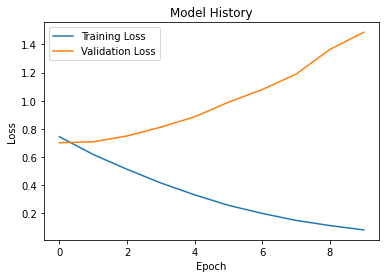

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

The validation accuracy was only slightly better than random guessing. 
We can alleviate this problem by using a higher dropout percentage or using less neurons in the LSTM layer.

The character-level model can be extremely good at modeling a language, given a broad enough dataset

In [50]:
# 9.22 Save the model for later

model_structure = model.to_json()
with open("/content/drive/My Drive/imdb/char_lstm_model3.json", "w") as json_file:
  json_file.write(model_structure)
model.save_weights("char_lstm_weights3.h5")

### **Character-based text generation using Gutenberg dataset**

We looked at character-level modeling using the IMDb dataset. Though there was overfitting, we learnt that simple character-level modeling is the gateway to more-complex models — ones that can not only pick up on details such as spelling, but also grammar and punctuation. When we make these models, we can generate novel text that has a peculiar style. 

To generate novel text, we can not use the IMDb dataset because of two issues:

-  It’s diverse and it’s written by many writers, each with their own writing style and personality. Finding commonalities across them all is difficult.
- It’s an extremely small dataset for learning a general character-based
language model.

We will dive into character-based text generation using the Gutenberg dataset with text by William Shakespeare. 

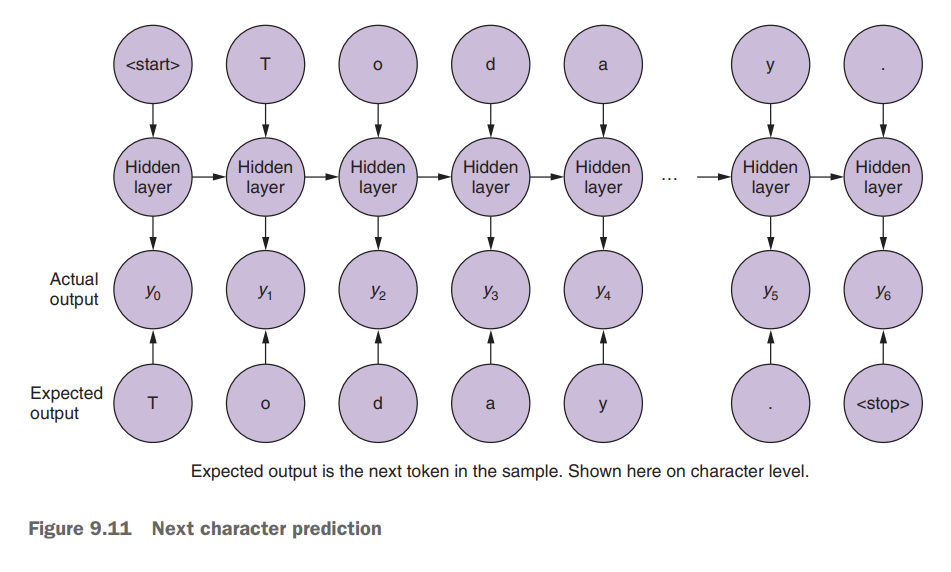

In [51]:
# 9.23 Download the Project Gutenberg dataset 

import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
gutenberg.fileids()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [52]:
# 9.24 Preprocess Shakespeare plays

# Concatenate all Shakespeare plays in the Gutenberg corpus in NLTK.
text = ''
for txt in gutenberg.fileids():
  if 'shakespeare' in txt:
    text += gutenberg.raw(txt).lower()

chars = sorted(list(set(text)))

# Make a dictionary of characters to an index, for reference in the one-hot encoding.
char_indices = dict((c, i) for i, c in enumerate(chars))

# Make the opposite dictionary for lookup when interpreting the one-hot encoding back to the character.
indices_char = dict((i, c) for i, c in enumerate(chars))

'corpus length: {} total chars: {}'.format(len(text), len(chars))

'corpus length: 375542 total chars: 50'

In [53]:
# First 1000 characters 
print(text[:1000])

[the tragedie of julius caesar by william shakespeare 1599]


actus primus. scoena prima.

enter flauius, murellus, and certaine commoners ouer the stage.

  flauius. hence: home you idle creatures, get you home:
is this a holiday? what, know you not
(being mechanicall) you ought not walke
vpon a labouring day, without the signe
of your profession? speake, what trade art thou?
  car. why sir, a carpenter

   mur. where is thy leather apron, and thy rule?
what dost thou with thy best apparrell on?
you sir, what trade are you?
  cobl. truely sir, in respect of a fine workman, i am
but as you would say, a cobler

   mur. but what trade art thou? answer me directly

   cob. a trade sir, that i hope i may vse, with a safe
conscience, which is indeed sir, a mender of bad soules

   fla. what trade thou knaue? thou naughty knaue,
what trade?
  cobl. nay i beseech you sir, be not out with me: yet
if you be out sir, i can mend you

   mur. what mean'st thou by that? mend mee, thou
sawcy fellow?

In [54]:
# 9.25 Assemble a training set

# We are going to chop up the source text into data samples, each with a fixed,
# set of characters defined by maxlen. To increase the dataset size and focus on consistent patterns, 
# this example oversamples the data into semi-redundant chunks. Take 40 characters from the beginning, 
# move to the third character from the beginning, take 40 from there, move to sixth … and so on.
# The goal of this particular model is to learn to predict the 41st character in any sequence, given the 40
# characters that came before it. So we’ll build a training set of semi-redundant sequences, each 40 characters long

maxlen = 40
step = 3

# Ignore sentence (and line) boundaries for now, so the character-based model will learn when to halt a sentence with a period ('.') or linefeed character ('\n').
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
  sentences.append(text[i: i + maxlen])
  next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 125168


In [55]:
sentences[0], sentences[1]

('[the tragedie of julius caesar by willia',
 'e tragedie of julius caesar by william s')

So we have 125,168 training samples and the character that follows each of them, the target for our model.

In [56]:
# 9.26 One-hot encode the training examples

# We one-hot encode each character of each sample in the dataset and store it as
# the list X. We also store the list of one-hot encoded “answers” in the list y

import numpy as np

X = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    X[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

In [57]:
len(X), len(y)

(125168, 125168)

In [58]:
# 9.27  Assemble a character-based LSTM model for generating text

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model = Sequential()

# We use a much wider LSTM layer with 128 neurons and we do not return
# the sequence. We only want the last output character.

model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["categorical_accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               91648     
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________


- We use 128 neurons in the hidden layer of LSTM cell because we are tyring to model much more complex behavior in reproducing a given text’s tone. 

- Major change is no dropout. We are looking to specifically model this dataset, overfitting is ideal.

-  The last layer in the network is a softmax, the output vector will be a probability distribution over all possible outputs of the network.

- Using categorical_crossentropy we are trying to minimize the difference
between the resultant probability distribution and the one-hot encoded expected
character.

In [59]:
# 9.28  Train your Shakespearean chatbot

epochs = 50
batch_size = 128
model_structure = model.to_json()
with open("shakes_lstm_model.json", "w") as json_file:
  json_file.write(model_structure)


history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
783/783 [==============================] - 7s 7ms/step - loss: 2.1027 - categorical_accuracy: 0.3833 - val_loss: 1.9284 - val_categorical_accuracy: 0.4368
Epoch 2/50
783/783 [==============================] - 5s 7ms/step - loss: 1.7196 - categorical_accuracy: 0.4821 - val_loss: 1.8190 - val_categorical_accuracy: 0.4610
Epoch 3/50
783/783 [==============================] - 5s 7ms/step - loss: 1.6019 - categorical_accuracy: 0.5116 - val_loss: 1.7591 - val_categorical_accuracy: 0.4831
Epoch 4/50
783/783 [==============================] - 5s 7ms/step - loss: 1.5269 - categorical_accuracy: 0.5345 - val_loss: 1.7411 - val_categorical_accuracy: 0.4854
Epoch 5/50
783/783 [==============================] - 5s 7ms/step - loss: 1.4770 - categorical_accuracy: 0.5472 - val_loss: 1.7389 - val_categorical_accuracy: 0.4909
Epoch 6/50
783/783 [==============================] - 5s 7ms/step - loss: 1.4402 - categorical_accuracy: 0.5586 - val_loss: 1.7487 - val_categorical_accuracy: 0.4841
Epoc

We get a validation accuracy of 48%.

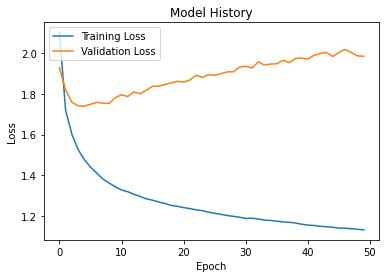

In [60]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

When I run 50 epochs, we can see gap between training and validation loss widening after 5 epochs. That is a clear sign of overfitting. But, overfiiting is ideal in this use case since we are trying to generate text based on a specific pattern. So, model should learn the underlying pattern in training data well. 

In [61]:
# 9.29  Sampler to generate character sequences

import random
def sample(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [62]:
# 9.30 Generate three texts with three diversity levels

import sys
start_index = random.randint(0, len(text) - maxlen - 1)
for diversity in [0.2, 0.5, 1.0]:
  print()
  print('----- diversity:', diversity)
  generated = ''
  sentence = text[start_index: start_index + maxlen]
  generated += sentence
  print('----- Generating with seed: "' + sentence + '"')
  sys.stdout.write(generated)
  for i in range(400):
    x = np.zeros((1, maxlen, len(chars)))

    # We seed the trained network and see what it spits out as the next character.
    for t, char in enumerate(sentence):
      x[0, t, char_indices[char]] = 1.

    # Model makes a prediction
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)

    # Look up which character that index represents.
    next_char = indices_char[next_index]
    generated += next_char

    # Add it to the “seed” and drop the first character to keep the length the same. This is now the seed for the next pass.
    sentence = sentence[1:] + next_char
    sys.stdout.write(next_char)

    # Flushes the internal buffer to the console so your character appears immediately
    sys.stdout.flush()
  print()


----- diversity: 0.2
----- Generating with seed: "t comes vpon me: art thou any thing?
art"
t comes vpon me: art thou any thing?
art me to the diuell, and be call the come,
and the commistion in the diuels, and the sound
it were then the compard mothers spirit to see,
that in the words if the selues, and the matter

   ham. i will be do not the comming and be bestide,
and with the barket the streete, and the man
that it selfe the selues, and the strife,
but in the countent to the things. i wi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


ll not this many
be call the diuell

----- diversity: 0.5
----- Generating with seed: "t comes vpon me: art thou any thing?
art"
t comes vpon me: art thou any thing?
art onely thinke and be remember my sound
it holding sight, and loue him thee may

   cassi. i did you that the bende thinke and lighte,
which my selfe to be brutus, and what make
you and for your fathers blood vpon this:
i that not starte, my lord, oh bathers entrimes to come
in the pectinin how he here is at him,
that i am be my deere all the generall

   ham. do not this bones

   ham. and this of

----- diversity: 1.0
----- Generating with seed: "t comes vpon me: art thou any thing?
art"
t comes vpon me: art thou any thing?
art hreet to incests will but her cassius,
that set of a feep'd. mine reade about and leaue,
with innocdie vs'st no more: yen let him
incerfull vs' arme lowges, you are minde,
and yet what truty hight be begen that-rath acted,
then ming o'res the sounderon

   guil. cutusgh, brutus is thy deaice, if

Diversity 0.2 and 0.5 both give us something that looks a little like Shakespeare. Diversity 1.0 (given this dataset) starts to go off the rails fairly quickly, but some basic structures, such as the line break followed by a character’s abbreviated name, still show up.

### **Other Kinds of Memory**

The **Gated Recurrent Unit (GRU)** combines the forget gate and the candidate choice branch from the candidate gate into a single update gate. This gate saves on the number of parameters to learn and has been shown to be comparable to a standard LSTM while being that much less computationally expensive.

In [63]:
# 9.31 Gated recurrent units in Keras

num_neurons = 128

from keras.models import Sequential
from keras.layers import GRU
model = Sequential()
model.add(GRU(num_neurons, return_sequences=True, input_shape=X[0].shape))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 128)           69120     
                                                                 
Total params: 69,120
Trainable params: 69,120
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 9.32 Two LSTM layers

from keras.models import Sequential
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=X[0].shape))
model.add(LSTM(num_neurons, return_sequences=True))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 40, 128)           91648     
                                                                 
 lstm_6 (LSTM)               (None, 40, 128)           131584    
                                                                 
Total params: 223,232
Trainable params: 223,232
Non-trainable params: 0
_________________________________________________________________


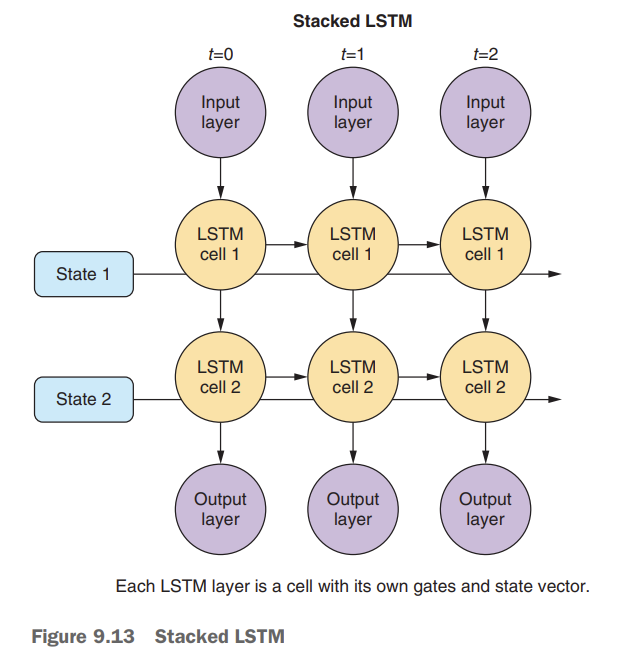

## **Conclusion**: 
Using this notebook, I have tried to analyze the disadvantages of using traditional RNN for text data. They suffer from vanishing/explodient gradient problem and tend to forget the words after a certain state of time. But in many languages like English, a word that appears first might be related to the second last word in a long sentence. These kind of dependencies in English language exists often and a traditional RNN model fails to detect such cases. Common NLP applications such as Text Summarization, Sentence Completion, Machine Translation can't work well if we do not save the information while modeling.

LSTMs and GRUs are type of Recurrent Neural Networks that allows us to store information with memory units and the fascinating part is that they can be trained on what information to store and what information to discard. This is achieved by using 4 feed-forward neural networks inside an LSTM cell. 

I used IMDB review dataset consisting of 25000 sentences (12500 negative and 12500 positive reviews) to make a sentiment classification word based model. Each word was converted into a numerical representation known as word embeddings by using pre-trained embeddings trained on the Google News dataset. It contains embeddings for 3 million words. NLPIA package has a function to load word2vec representations but I used gensim. 

Our initial model consisted of a single LSTM layer with dropout (to avoid overfitting). It achieved an accuracy of ~81% but it was trained on only 5000 randomly sampled sentences due to high memory requirement. If the system allowed more data, accuracy would have been more. I used different epochs, batch_size, number of neurons in LSTM layer and the maximum token length in each sentence to make a more accurate model but accuracy remained around 82%.



Relation between words is difficult to model than predicting the next character given some character sequence. Even though character-modeling is not used these days, I have used character modeling for sentiment classification. That model was overfit with ~99% train accuracy and only ~52% validation accuracy which is almost similar to random guessing.

But, even though character modeling can't be used to figure out sentiment of a sentence, it can be used to generate text similar to Shakespeare writing style. For this model, I have used Shakespeare sonnet from the Gutenberg project. When we are trying to generate text based on some defined pattern (tone and syntax similar to Shakespeare), overfitting is ideal. I get a validation accuracy of ~50% but this not same as randomly guessing the next character because next character could be from a set of 50 different characters. 

Overall, we have used IMDB dataset for sentiment classification, with word-level modeling and character level modeling approach. We got into character modeling to study how NLP applications like text generation work.

## **References**

1. [NLPIA Chapter 9](https://livebook.manning.com/book/natural-language-processing-in-action/chapter-9/1)

2. [TensorFlow text generation using RNN](https://www.tensorflow.org/text/tutorials/text_generation)

3. [LSTM: Understanding the Number of Parameters](https://medium.com/deep-learning-with-keras/lstm-understanding-the-number-of-parameters-c4e087575756)

4. [CS 230: Deep Learning](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)

5. [The Complete LSTM Tutorial](https://www.analyticsvidhya.com/blog/2022/01/the-complete-lstm-tutorial-with-implementation/)